In [12]:
#ITO-2
L = 3/10**3
L_film = 150/10**9
Long = 1024
border_start = 5
border_stop = 80
f_name = ["/home/meriff/Python_projects/ITO_measurment/air1",
        "/home/meriff/Python_projects/ITO_measurment/substrate_air1",
        "/home/meriff/Python_projects/ITO_measurment/sample1_air1"]

In [44]:
#ITO-2_second
L = 3/10**3
L_film = 150/10**9
Long = 1024
border_start = 4
border_stop = 80
f_name = ["/home/meriff/Python_projects/ITO_measurment/air2",
        "/home/meriff/Python_projects/ITO_measurment/substrate_air2",
        "/home/meriff/Python_projects/ITO_measurment/sample1_air2"]

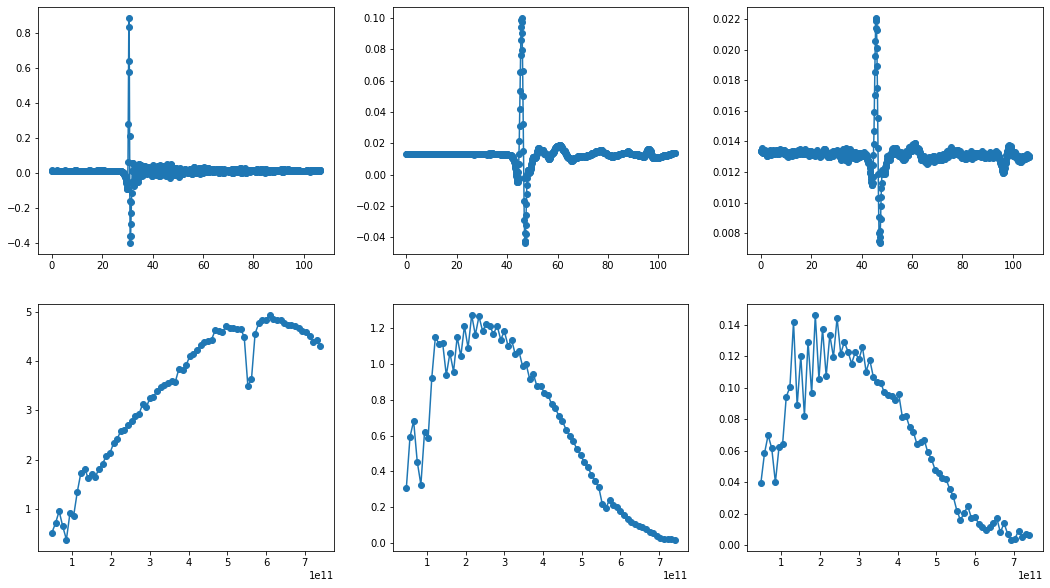

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
import math
from IPython.display import clear_output

def read_info(f_name):
    handle = open(f_name, "r")
    data = []
    for line in handle:
        data.append([float(x) for x in line.split()])
    handle.close()
    timer_f=[]; signal_f=[]; N=len(data)
    for i in range (0,Long):
        timer_f.append(data[i][0])
        signal_f.append(data[i][1])
    dT = timer_f[1]-timer_f[0]
   # for i in range (N,Long):
    #    timer_f.append(i*dT+dT)
     #   signal_f.append(0)
    return timer_f, signal_f,N

timer=np.zeros(Long)
signal=np.zeros((3,Long))
length_s=np.zeros(3)

for i in range (0,3):
    timer,signal[i],N = read_info(f_name[i])
    length_s[i] = N

dT = (timer[1] - timer[0])/10**12
frequency = np.fft.fftfreq(Long, dT)

signal_w=np.fft.fft(signal,axis=1)            #here fft is done
plt.rcParams['figure.figsize'] = [18,10]
fig,a=plt.subplots(2, 3)

for i in range(0,3):
    N=Long#int(length_s[i])
    a[0][i].plot(timer[0:N], signal[i,0:N], 'o-')
    a[1][i].plot(frequency[border_start:border_stop],np.abs(signal_w[i,border_start:border_stop]),'o-')
plt.show()

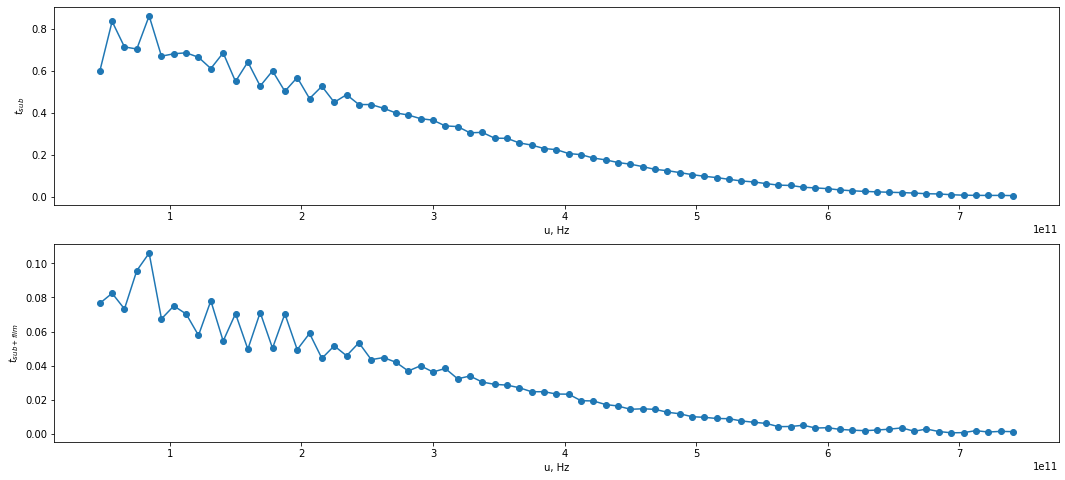

In [14]:
plt.rcParams['figure.figsize'] = [18,8]
titles = ["$t_{sub}$",
         "$t_{sub+flim}$"]
fig,a=plt.subplots(2)
for i in range (0,2):
    a[i].plot(frequency[border_start:border_stop],abs(signal_w[i+1,border_start:border_stop]/signal_w[0,border_start:border_stop]),'o-')
    a[i].set_ylabel(titles[i])
    a[i].set_xlabel('u, Hz')

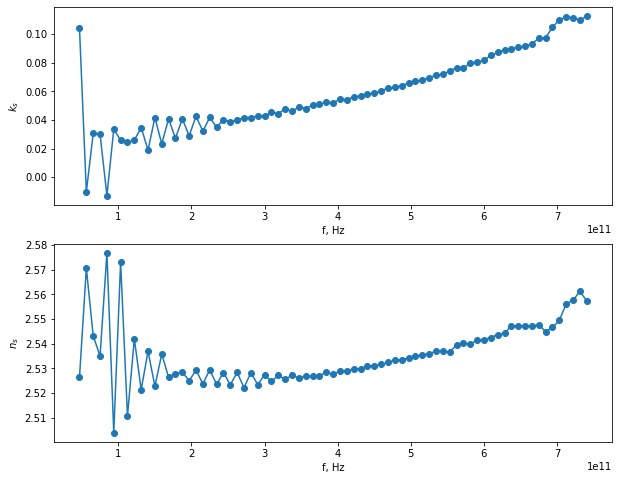

In [18]:
ph=np.zeros(border_stop); ph_gauss=np.zeros(border_stop)
H = np.zeros(border_stop, dtype = complex)
n_simple=np.zeros(border_stop)
k_simple=np.zeros(border_stop)
for i in range (border_start,border_stop):
    H[i] = signal_w[1,i]/signal_w[0,i]
    ph[i] = cmath.phase(H[i])
ph=np.unwrap(ph)-2*math.pi

wlc = np.zeros(border_stop)
for i in range (border_start,border_stop):
    wlc[i] = frequency[i]*2*math.pi*L/(3*10**8)
    
for i in range (border_start,border_stop):
    n_simple[i] = 1 - (ph[i])/wlc[i]
    k_simple[i] = math.log(4*n_simple[i]/((n_simple[i]+1)**2)/abs(H[i]))/wlc[i]

plt.rcParams['figure.figsize'] = [10,8]
fig,a=plt.subplots(2)
a[0].plot(frequency[border_start:border_stop], k_simple[border_start:border_stop], 'o-')
a[0].set_ylabel('$k_s$')
a[0].set_xlabel('f, Hz')
a[1].plot(frequency[border_start:border_stop], n_simple[border_start:border_stop], 'o-')
a[1].set_ylabel('$n_s$')
a[1].set_xlabel('f, Hz')
#a[2].plot(frequency[border_start:border_stop], ph[border_start:border_stop], 'o-')
#a[2].set_ylabel('phase')
#a[2].set_xlabel('f, Hz')
plt.show()

Counted 100 %
True width is 3000.0 mkm


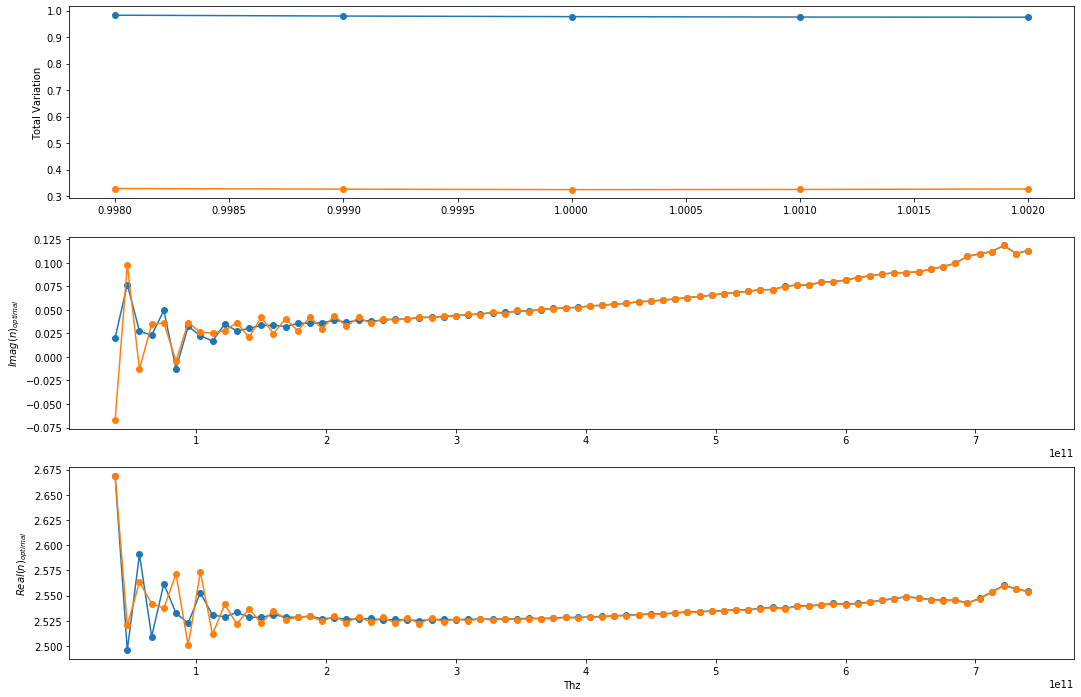

In [48]:
#counts iterative n and k with respect to Fabri-Pero effect (Mira pages 44-45) 
H_model=np.zeros(border_stop, dtype = complex)
epsilon = 0.01
counter = 0
Total_err = 1
control=[]
dzeta_ar = np.arange(0.998,1.002,0.001)
TV_ar = []
TV2_ar = []
dzeta_opt = 0.
TV_min=10000
for dzeta in dzeta_ar:
    for i in range (border_start,border_stop):
        wlc[i] = frequency[i]*2*math.pi*L*dzeta/(3*10**8)
    n_new=np.copy(n_simple)
    k_new=np.copy(k_simple)
    ER_m=np.zeros(border_stop)
    ER_p=np.zeros(border_stop)
    counter = 0
    Total_err = 1
    while (counter < 2000) and (Total_err > epsilon):
        n=np.copy(n_new);   k=np.copy(k_new)
        for i in range (border_start,border_stop):
            n_hat = n[i] - 1.j*k[i]
            H_model[i] = 4*n_hat/(n_hat+1)**2 * cmath.exp(-1.j*(n_hat-1)*wlc[i])
            q = ((1-n_hat)/(n_hat+1))**2 * cmath.exp(-2.j*n_hat*wlc[i])
            H_model[i] = H_model[i] /(1-q)
            ER_p[i] = cmath.phase(H_model[i])
        ER_p = np.unwrap(ER_p)
        for i in range (border_start,border_stop):
            ER_p[i] = ph[i]+ 2*math.pi - ER_p[i]
            ER_m[i] = abs(H[i]) - abs(H_model[i])
            n_new[i] = n[i] - epsilon*ER_p[i]
            k_new[i] = k[i] - epsilon*ER_m[i]
        Total_err = 0
        counter = counter + 1
        for i in range (border_start,border_stop):
            Total_err +=  abs(ER_p[i]) + abs(ER_m[i])
    TV=0; TV2 = 0    
    if (Total_err < epsilon):
        for i in range (border_start,border_stop-1):
            TV += abs(k[i+1]-k[i]) + abs(n[i+1]-n[i])
        for i in range (border_start, border_stop-2):
            TV2 += abs(abs(k[i+2]-k[i+1]) + abs(n[i+2]-n[i+1]) - abs(k[i+1]-k[i]) - abs(n[i+1]-n[i]))
    if TV_min>TV2:
        L_true = dzeta*L
        TV_min=TV2
        n_opt=np.copy(n)
        k_opt=np.copy(k)
        wlc_true = np.copy(wlc)
    
    TV_ar.append(TV)
    TV2_ar.append(TV2)
    percent = (dzeta-dzeta_ar[0])/(dzeta_ar[-1]-dzeta_ar[0])*100
    clear_output(wait=True)
    print("Counted", int(percent),"%")
print("True width is", L_true*10**6, "mkm")
shift = 0
fig,a=plt.subplots(3)
a[0].plot(dzeta_ar, TV_ar, 'o-')
a[0].plot(dzeta_ar, TV2_ar, 'o-')
a[0].set_ylabel('Total Variation')
a[1].plot(frequency[border_start+shift:border_stop], k_opt[border_start+shift:border_stop], 'o-', label='Mira')
a[1].plot(frequency[border_start+shift:border_stop], k_simple[border_start+shift:border_stop],'o-', label='Simple')
a[1].set_ylabel('$Imag(n)_{optimal}$')
a[2].plot(frequency[border_start+shift:border_stop], n_opt[border_start+shift:border_stop], 'o-', label='Mira')
a[2].plot(frequency[border_start+shift:border_stop], n_simple[border_start+shift:border_stop],'o-', label='Simple')
a[2].set_ylabel('$Real(n)_{optimal}$')
a[2].set_xlabel('Thz')
plt.show()

In [49]:
k_opt2 = np.copy(k_opt)
n_opt2 = np.copy(n_opt)

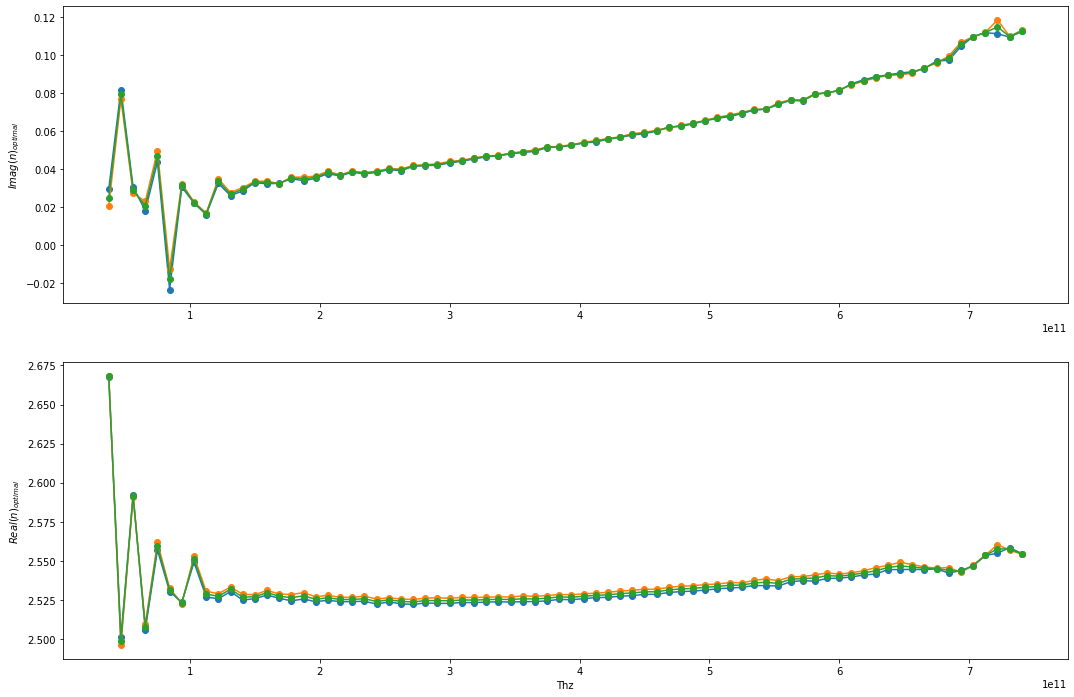

In [50]:
k_sub = (k_opt2 + k_opt1)/2
n_sub = (n_opt2 + n_opt1)/2

shift=0
fig,a=plt.subplots(2)
a[0].plot(frequency[border_start+shift:border_stop], k_opt1[border_start+shift:border_stop], 'o-', label='1')
a[0].plot(frequency[border_start+shift:border_stop], k_opt2[border_start+shift:border_stop],'o-', label='2')
a[0].plot(frequency[border_start+shift:border_stop], k_sub[border_start+shift:border_stop],'o-', label='avergae')
a[0].set_ylabel('$Imag(n)_{optimal}$')
a[1].plot(frequency[border_start+shift:border_stop], n_opt1[border_start+shift:border_stop], 'o-', label='1')
a[1].plot(frequency[border_start+shift:border_stop], n_opt2[border_start+shift:border_stop],'o-', label='2')
a[1].plot(frequency[border_start+shift:border_stop], n_sub[border_start+shift:border_stop],'o-', label='average')
a[1].set_ylabel('$Real(n)_{optimal}$')
a[1].set_xlabel('Thz')
plt.show()

In [51]:
data = np.zeros((border_stop,3))
for i in range (0,2):
    for j in range (0,border_stop):
        data[j,0] = frequency[j]
        data[j,1] = k_sub[j]
        data[j,2] = n_sub[j]
np.savetxt('refr_sub_1024',data, delimiter='   ')